# CNN for Trading - Part 3: Training and Evaluating a CNN

To exploit the grid-like structure of time-series data, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

An alternative approach converts a time series of alpha factors into a two-dimensional format to leverage the ability of CNNs to detect local patterns. [Sezer and Ozbayoglu (2018)](https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach) propose CNN-TA, which computes 15 technical indicators for different intervals and uses hierarchical clustering (see Chapter 13, Data-Driven Risk Factors and Asset Allocation with Unsupervised Learning) to locate indicators that behave similarly close to each other in a two-dimensional grid.

The authors train a CNN similar to the CIFAR-10 example we used earlier to predict whether to buy, hold, or sell an asset on a given day. They compare the CNN performance to "buy-and-hold" and other models and find that it outperforms all alternatives using daily price series for Dow 30 stocks and the nine most-traded ETFs over the 2007-2017 time period.

The section on *CNN for Trading* consists of three notebooks that experiment with this approach using daily US equity price data. They demonstrate 
1. How to compute relevant financial features
2. How to convert a similar set of indicators into image format and cluster them by similarity
3. How to train a CNN to predict daily returns and evaluate a simple long-short strategy based on the resulting signals.

## Creating and training a convolutional neural network

Now we are ready to design, train, and evaluate a CNN following the steps outlined in the
previous section.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import sys, os

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
size = 15
lookahead = 1

In [7]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

In [8]:
with pd.HDFStore('data.h5') as store:
    features = store['img_data']
    targets = store['targets']

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2372451 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('UAL', Timestamp('2017-12-29 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(225)
memory usage: 2.0+ GB


In [10]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2372451 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('UAL', Timestamp('2017-12-29 00:00:00'))
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   r01_fwd     float64
 1   r01dec_fwd  float64
 2   r05_fwd     float64
 3   r05dec_fwd  float64
dtypes: float64(4)
memory usage: 81.6+ MB


In [11]:
outcome = f'r{lookahead:02}_fwd'
features = features.join(targets[[outcome]]).dropna()
target = features[outcome]
features = features.drop(outcome, axis=1)

In [12]:
features

01_CMO    01_ROC   01_NATR    01_PPO   01_MACD  \
symbol date                                                            
A      2001-01-02 -34.412796 -0.973141  6.947728  0.585962  0.535624   
       2001-01-03  12.697194  2.633023  7.902791  1.489047  0.595197   
       2001-01-04  25.371769  8.878505  7.599194  2.874703  0.749336   
       2001-01-05  -0.667682 -1.573114  8.137382  2.481612  0.688751   
       2001-01-08 -12.974548 -3.724462  8.088328  1.464707  0.535229   
...                      ...       ...       ...       ...       ...   
UAL    2017-12-21  74.251938  6.742821  2.037865  3.816215  1.137698   
       2017-12-22  72.923820  6.526216  1.790676  4.177783  1.260976   
       2017-12-26  73.724876  5.630489  1.796622  4.353743  1.349521   
       2017-12-27  60.610138  3.965304  1.753085  4.296589  1.386643   
       2017-12-28  66.201279  4.826944  1.622089  4.300513  1.428754   

                     01_CMA    01_RMW    01_HML  01_Market    01_SMB  ...  \
symbol date                                                           ...   
A      2001-01-02  0.023726 -0.005678 -0.016883   0.013480 -0.010002  ...   
       2001-01-03  0.015790 -0.008903 -0.019513   0.009477 -0.019619  ...   
       2001-01-04  0.009270 -0.002958 -0.025395   0.003335 -0.011481  ...   
       2001-01-05  0.005425 -0.003742 -0.019646   0.004832 -0.008056  ...   
       2001-01-08 -0.011127 -0.002551  0.004207   0.011870  0.009249  ...   
...                     ...       ...       ...        ...       ...  ...   
UAL    2017-12-21  0.001991 -0.009208  0.000501   0.006544  0.009370  ...   
       2017-12-22  0.000357 -0.013665  0.003962   0.002607  0.009963  ...   
       2017-12-26 -0.008803 -0.026155 -0.002756   0.005423  0.009199  ...   
       2017-12-27 -0.007756 -0.025848 -0.002666   0.005640  0.009230  ...   
       2017-12-28 -0.000634 -0.026850 -0.003354   0.008750  0.009394  ...   

                     11_CMA    11_RMW    11_HML  11_Market    11_SMB  \
symbol date                                                            
A      2001-01-02 -0.001141  0.001600 -0.002749   0.017469  0.008099   
       2001-01-03 -0.000315  0.002055 -0.004466   0.016901  0.006435   
       2001-01-04 -0.001298  0.002811 -0.006195   0.015803  0.009960   
       2001-01-05 -0.001612  0.001296 -0.004640   0.016019  0.009051   
       2001-01-08  0.000528  0.001390 -0.004773   0.017322  0.010696   
...                     ...       ...       ...        ...       ...   
UAL    2017-12-21  0.002668 -0.001175  0.001739   0.014169  0.006841   
       2017-12-22  0.002677 -0.001149  0.001683   0.014153  0.006827   
       2017-12-26  0.002909 -0.000884  0.001478   0.014803  0.006483   
       2017-12-27  0.003029 -0.000783  0.001485   0.014805  0.006567   
       2017-12-28  0.002378 -0.000511  0.001356   0.015193  0.006338   

                     11_BBH    11_BBL     11_RSI     11_EMA     11_WMA  
symbol date                                                             
A      2001-01-02  0.151378  0.004491  46.341988  36.953236  37.318768  
       2001-01-03  0.066146  0.090595  54.497822  37.110992  37.350422  
       2001-01-04  0.034141  0.120748  57.293777  37.420349  37.568836  
       2001-01-05  0.080985  0.075976  52.150497  37.437271  37.528706  
       2001-01-08  0.102645  0.049909  49.463108  37.306923  37.354282  
...                     ...       ...        ...        ...        ...  
UAL    2017-12-21 -0.014244  0.087697  71.777733  63.719887  64.281616  
       2017-12-22 -0.002536  0.090688  71.576576  64.135193  64.696030  
       2017-12-26  0.004949  0.092025  71.857010  64.513405  65.093307  
       2017-12-27  0.014465  0.087292  70.158813  64.820068  65.428383  
       2017-12-28  0.013936  0.088690  71.472038  65.140060  65.779556  

[2351464 rows x 225 columns]

## Convolutional Neural Network

We again closely follow the authors in creating a CNN with 2 convolutional layers with kernel size 3 and 16 and 32 filters, respectively, followed by a max pooling layer of size 2. 

We flatten the output of the last stack of filters and connect the resulting 1,568 outputs to a dense layer of size 32, applying 25 and 50 percent dropout probability to the incoming and outcoming connections to mitigate overfitting.

### Model Architecture

In [13]:
def make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32):
    input_shape = (size, size, 1)
    cnn = Sequential([
        Conv2D(filters=filter1,
               kernel_size=3,
               padding='same',
               activation=act1,
               input_shape=input_shape,
               name='CONV1'),
        Conv2D(filters=filter2,        
               kernel_size=3,  
               padding='same',
               activation=act2,
               name='CONV2'),
        MaxPooling2D(pool_size=2, name='POOL2'),
        Dropout(do1, name='DROP1'),
        Flatten(name='FLAT1'),
        Dense(dense, activation='relu', name='FC1'),
        Dropout(do2, name='DROP2'),
        Dense(1, activation='linear', name='FC2')
    ])
    cnn.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, 
                                                  momentum=0.9, 
                                                  nesterov=False, 
                                                  name='SGD'),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return cnn

In [14]:
cnn = make_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 15, 15, 16)        160       
_________________________________________________________________
CONV2 (Conv2D)               (None, 15, 15, 32)        4640      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 7, 7, 32)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 7, 7, 32)          0         
_________________________________________________________________
FLAT1 (Flatten)              (None, 1568)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 32)                50208     
_________________________________________________________________
DROP2 (Dropout)              (None, 32)                0

### Train the Model

We cross-validate the model with the MutipleTimeSeriesCV train and validation set index generator introduced in Chapter 7, Linear Models – From Risk Factors to Return Forecasts. We provide 5 years of trading days during the training period in batches of 64 random samples and validate using the subsequent 3 months, covering the years 2014-2017.

In [15]:
train_period_length = 5 * 12 * 21
test_period_length = 5 * 21
n_splits = 16

In [16]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

We scale the features to the range [-1, 1] and again use NumPy's .reshape() method to create the requisite format: 

In [17]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    return (x_train.reshape(-1, size, size, 1), y_train,
            x_val.reshape(-1, size, size, 1), y_val)

In [17]:
batch_size = 64

In [18]:
checkpoint_path = results_path / f'lookahead_{lookahead:02d}'
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)

Training and validation follow the process laid out in Chapter 17, Deep Learning for Trading, relying on checkpointing to store weights after each epoch and generate predictions for the best-performing iterations without the need for costly retraining.

In [19]:
start = time()
ic  = []
for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
    X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
    preds = y_val.to_frame('actual')
    r = pd.DataFrame(index=y_val.index.unique(level='date')).sort_index()
    model = make_model(filter1=16, act1='relu', filter2=32, 
                       act2='relu', do1=.25, do2=.5, dense=32)
    best_mean = best_median = -np.inf
    for epoch in range(25):         
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  validation_data=(X_val, y_val),
                  epochs=epoch + 1,
                  initial_epoch=epoch,
                  verbose=0, shuffle=True)
        model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        preds[epoch] = model.predict(X_val).squeeze()
        r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
        print(f'{format_time(time()-start)} | {fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
    ic.append(r.assign(fold=fold))
ic = pd.concat(ic)
ic.to_csv(checkpoint_path / 'ic.csv')

00:01:53 | 01 | 01 | -0.0020 |  0.0052
00:03:34 | 01 | 02 |  0.0038 | -0.0232
00:05:35 | 01 | 03 |  0.0044 | -0.0144
00:07:30 | 01 | 04 |  0.0051 | -0.0110
00:09:27 | 01 | 05 |  0.0045 | -0.0088
00:11:21 | 01 | 06 |  0.0034 | -0.0125
00:13:08 | 01 | 07 |  0.0042 | -0.0079
00:14:52 | 01 | 08 |  0.0053 | -0.0064
00:16:36 | 01 | 09 |  0.0051 | -0.0107
00:18:20 | 01 | 10 |  0.0056 | -0.0116
00:20:05 | 01 | 11 |  0.0053 | -0.0124
00:21:47 | 01 | 12 |  0.0040 | -0.0092
00:23:25 | 01 | 13 |  0.0055 | -0.0093
00:25:03 | 01 | 14 |  0.0049 | -0.0095
00:26:41 | 01 | 15 |  0.0052 | -0.0052
00:28:19 | 01 | 16 |  0.0049 | -0.0082
00:29:54 | 01 | 17 |  0.0043 | -0.0078
00:31:31 | 01 | 18 |  0.0040 | -0.0167
00:33:04 | 01 | 19 |  0.0042 | -0.0115
00:34:39 | 01 | 20 |  0.0019 | -0.0159
00:36:15 | 01 | 21 |  0.0014 | -0.0158
00:37:49 | 01 | 22 |  0.0018 | -0.0123
00:39:23 | 01 | 23 |  0.0020 | -0.0138
00:40:55 | 01 | 24 |  0.0010 | -0.0138
00:42:28 | 01 | 25 |  0.0011 | -0.0147
00:44:14 | 02 | 01 | -0.0

05:47:28 | 09 | 12 |  0.0230 |  0.0213
05:49:04 | 09 | 13 |  0.0223 |  0.0267
05:50:41 | 09 | 14 |  0.0231 |  0.0219
05:52:14 | 09 | 15 |  0.0228 |  0.0224
05:53:47 | 09 | 16 |  0.0235 |  0.0262
05:55:20 | 09 | 17 |  0.0236 |  0.0271
05:56:53 | 09 | 18 |  0.0234 |  0.0264
05:58:26 | 09 | 19 |  0.0239 |  0.0250
06:00:00 | 09 | 20 |  0.0237 |  0.0252
06:01:34 | 09 | 21 |  0.0238 |  0.0257
06:03:07 | 09 | 22 |  0.0240 |  0.0229
06:04:41 | 09 | 23 |  0.0245 |  0.0203
06:06:14 | 09 | 24 |  0.0241 |  0.0229
06:07:47 | 09 | 25 |  0.0240 |  0.0230
06:09:25 | 10 | 01 | -0.0040 |  0.0037
06:11:00 | 10 | 02 | -0.0018 |  0.0023
06:12:38 | 10 | 03 | -0.0034 | -0.0095
06:14:14 | 10 | 04 | -0.0045 | -0.0037
06:15:51 | 10 | 05 | -0.0045 | -0.0052
06:16:51 | 10 | 06 | -0.0044 | -0.0077
06:17:53 | 10 | 07 | -0.0055 | -0.0108
06:18:56 | 10 | 08 | -0.0063 | -0.0030
06:19:58 | 10 | 09 | -0.0054 | -0.0113
06:20:59 | 10 | 10 | -0.0036 | -0.0062
06:22:01 | 10 | 11 | -0.0065 | -0.0120
06:23:04 | 10 | 12 | -0.0

### Evaluate results

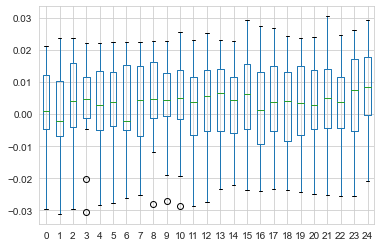

In [20]:
ic.groupby('fold').mean().boxplot();

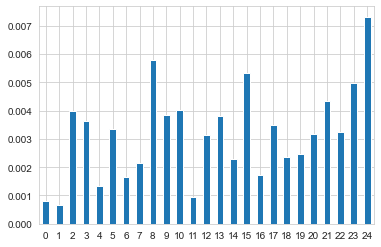

In [21]:
ic.groupby('fold').mean().mean().sort_index().plot.bar(rot=0);

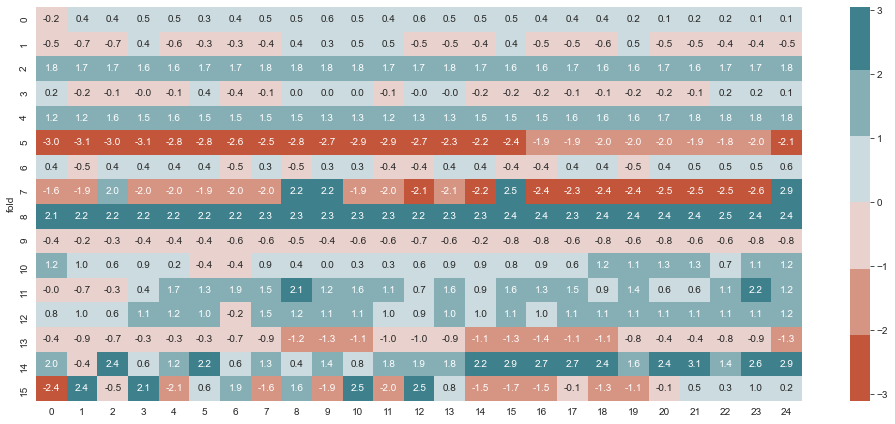

In [22]:
cmap = sns.diverging_palette(h_neg=20, h_pos=210)
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(ic.groupby('fold').mean().mul(100), ax=ax, center=0, cmap=cmap, annot=True, fmt='.1f')
fig.tight_layout()

## Make Predictions

To evaluate the model's predictive accuracy, we compute the daily information coefficient (IC) for the validation set like so:


In [23]:
def generate_predictions(epoch):
    predictions = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
        X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
        preds = y_val.to_frame('actual')
        model = make_model(filter1=16, act1='relu', filter2=32, 
                       act2='relu', do1=.25, do2=.5, dense=32)
        status = model.load_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(X_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [24]:
preds = {}
for i, epoch in enumerate(ic.drop('fold', axis=1).mean().nlargest(5).index):
    preds[i] = generate_predictions(epoch)

In [25]:
with pd.HDFStore(results_path / 'predictions.h5') as store:
    store.put('predictions', pd.DataFrame(preds).sort_index())